In [2]:
import ast
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

audio_df = pd.read_csv(
    '../audio_classification_3sec_deep_32.csv',
    converters={2: ast.literal_eval}
)

audio_df = audio_df.set_axis(['clip_id', 'genre', 'features', 'isAugmented'], axis=1)

records = []
for _, row in audio_df.iterrows():
    clip = row['clip_id']
    is_aug = row['isAugmented']
    genre  = row['genre']
    for seg_id, feat_vec in enumerate(row['features']):
        rec = {
            'clip_id':     clip,
            'isAugmented': is_aug,
            'segment_id':  seg_id,
            'genre':       genre
        }
        for i, v in enumerate(feat_vec):
            rec[f'feat_{i}'] = v
        records.append(rec)

seg_df = pd.DataFrame(records)
le = LabelEncoder()
seg_df['genre_idx'] = le.fit_transform(seg_df['genre'])

real_clips = audio_df[audio_df.isAugmented == 0]

train_clips_old, test_clips = train_test_split(
    real_clips, test_size=0.2, random_state=1122,
    stratify=real_clips['genre'], shuffle=True
)

train_clips, valid_clips = train_test_split(train_clips_old, test_size=0.1, random_state=1122, stratify=train_clips_old['genre'])

train_ids = train_clips['clip_id'].tolist()
test_ids = test_clips['clip_id'].tolist()
valid_ids = valid_clips['clip_id'].tolist()

train_ids_full = []
valid_ids_full = []

for id in train_ids:
    train_ids_full.append(id+1)
    train_ids_full.append(id+2)
    train_ids_full.append(id+3)
    train_ids_full.append(id+4)
    
for id in valid_ids:
    valid_ids_full.append(id)

train_df_clean = seg_df[seg_df.clip_id.isin(train_ids)] # real
train_df_aug = seg_df[seg_df.clip_id.isin(train_ids_full) & seg_df.isAugmented == 1] # augmented
train_df = pd.concat([train_df_clean, train_df_aug]) # real + augment
valid_df = seg_df[seg_df.clip_id.isin(valid_ids_full)] # real
test_df  = seg_df[seg_df.clip_id.isin(test_ids)] # real

feature_cols = [c for c in seg_df.columns if c.startswith('feat_')] + ['isAugmented']
X_train = train_df[feature_cols]
y_train = train_df['genre_idx']

X_valid = valid_df[feature_cols]
y_valid = valid_df['genre_idx']

X_test  = test_df[feature_cols]
y_test_segments = test_df['genre_idx']

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

In [70]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=1000,
    learning_rate=0.18,
    max_depth=3,
    booster="gbtree",
    random_state=1122,
    eval_metric='mlogloss',
    device='cuda',
    n_jobs=-1,
    early_stopping_rounds=20
)
clf.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_valid_scaled, y_valid)], verbose=True)

[0]	validation_0-mlogloss:2.08146	validation_1-mlogloss:2.10118
[1]	validation_0-mlogloss:1.93572	validation_1-mlogloss:1.96401
[2]	validation_0-mlogloss:1.82524	validation_1-mlogloss:1.86029
[3]	validation_0-mlogloss:1.73510	validation_1-mlogloss:1.77504
[4]	validation_0-mlogloss:1.65914	validation_1-mlogloss:1.70924
[5]	validation_0-mlogloss:1.59130	validation_1-mlogloss:1.65066
[6]	validation_0-mlogloss:1.53173	validation_1-mlogloss:1.59403
[7]	validation_0-mlogloss:1.47935	validation_1-mlogloss:1.54542
[8]	validation_0-mlogloss:1.43106	validation_1-mlogloss:1.49733
[9]	validation_0-mlogloss:1.38912	validation_1-mlogloss:1.46358
[10]	validation_0-mlogloss:1.34884	validation_1-mlogloss:1.42966
[11]	validation_0-mlogloss:1.31237	validation_1-mlogloss:1.38979
[12]	validation_0-mlogloss:1.27720	validation_1-mlogloss:1.35851
[13]	validation_0-mlogloss:1.24622	validation_1-mlogloss:1.33428
[14]	validation_0-mlogloss:1.21827	validation_1-mlogloss:1.30553
[15]	validation_0-mlogloss:1.19054	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [71]:
test_df = test_df.assign(pred_seg=clf.predict(X_test_scaled))

clip_preds = {
    cid: Counter(grp['pred_seg']).most_common(1)[0][0]
    for cid, grp in test_df.groupby('clip_id')
}

clip_summary = (
    test_df
    .groupby('clip_id')
    .agg(
       true = ('genre_idx', 'first'),
       pred = ('pred_seg', lambda x: Counter(x).most_common(1)[0][0])
    )
)

from sklearn.metrics import accuracy_score
print("file-level acc:", accuracy_score(clip_summary['true'], clip_summary['pred']))

y_true = test_df['genre_idx'].tolist()
print("clip-level acc:", accuracy_score(test_df['pred_seg'], y_true))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multiclass Confusion Matrix')
    plt.show()

file-level acc: 0.87
clip-level acc: 0.8045


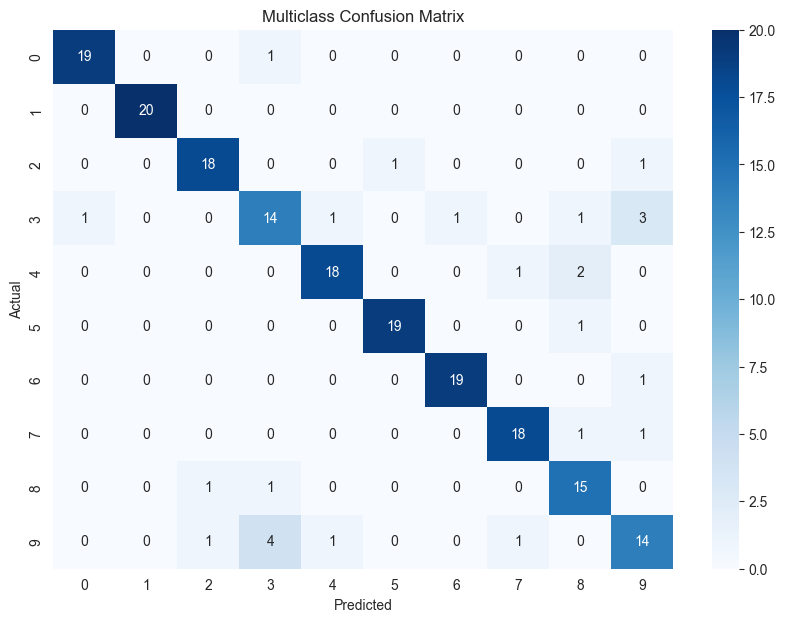

In [72]:
plot_confusion_matrix(clip_summary['pred'], clip_summary['true'], labels=y_test_segments.unique())

In [73]:
print(classification_report(y_true=clip_summary['true'], y_pred=clip_summary['pred']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       1.00      1.00      1.00        20
           2       0.90      0.90      0.90        20
           3       0.67      0.70      0.68        20
           4       0.86      0.90      0.88        20
           5       0.95      0.95      0.95        20
           6       0.95      0.95      0.95        20
           7       0.90      0.90      0.90        20
           8       0.88      0.75      0.81        20
           9       0.67      0.70      0.68        20

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



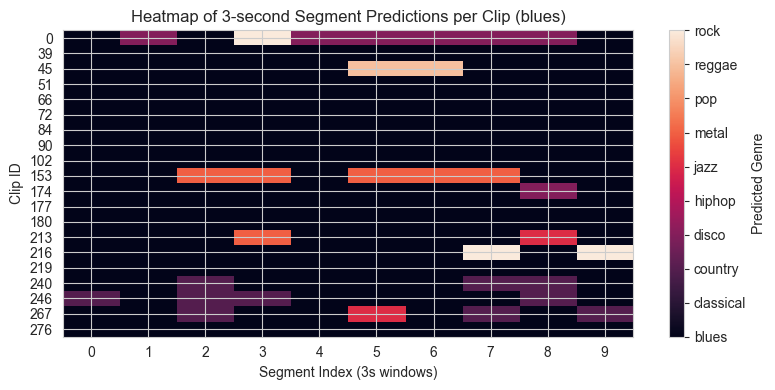

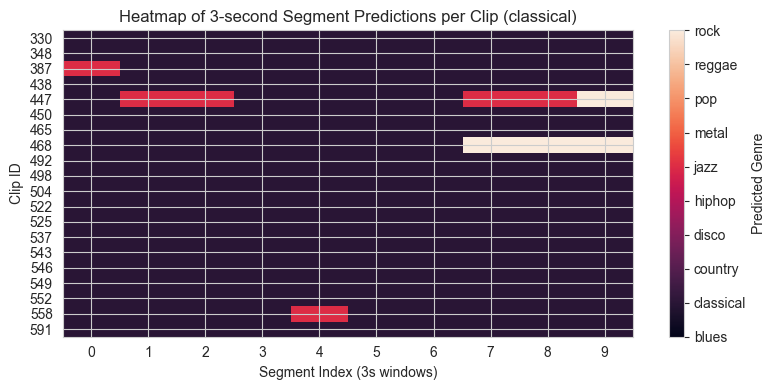

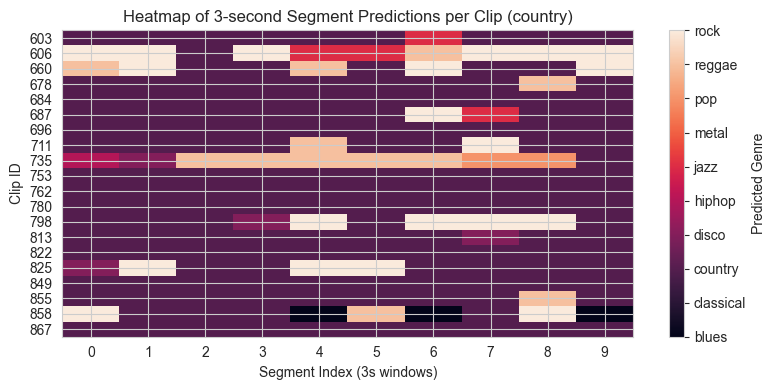

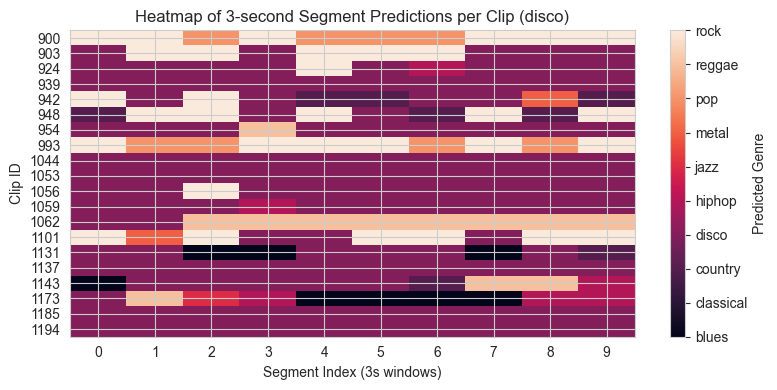

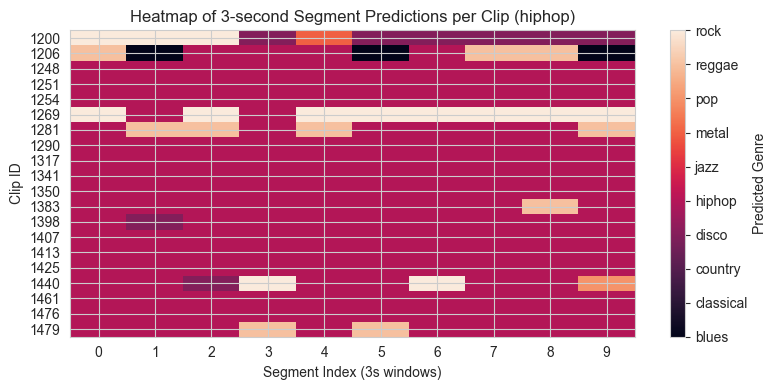

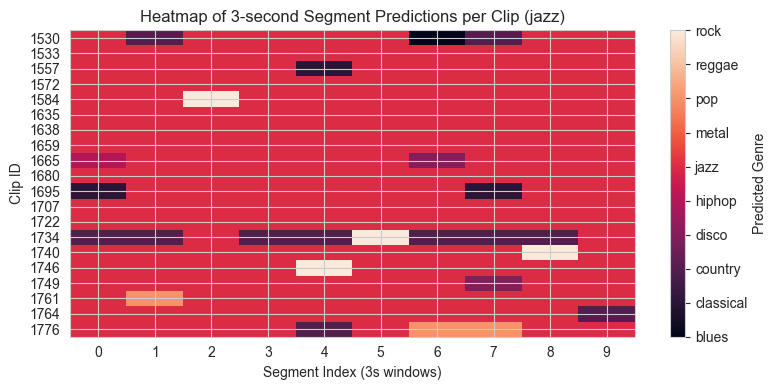

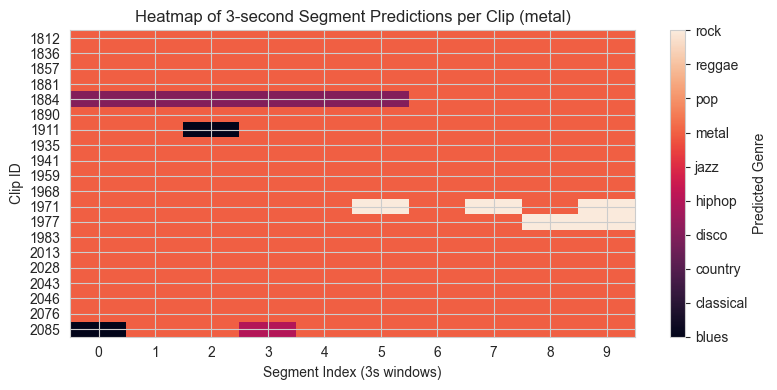

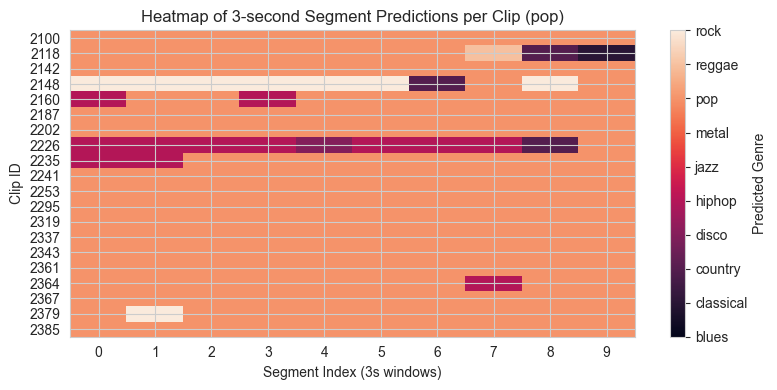

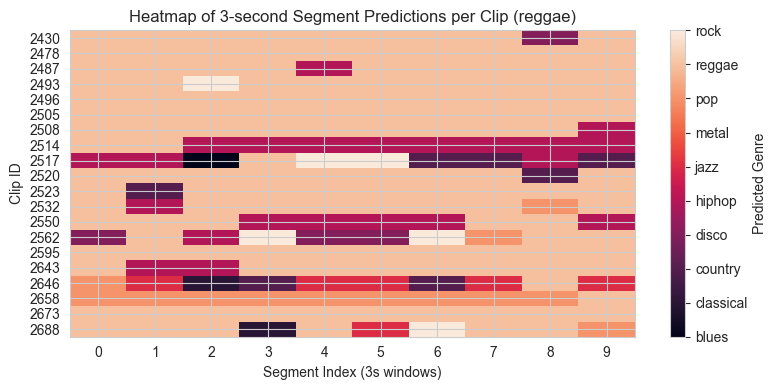

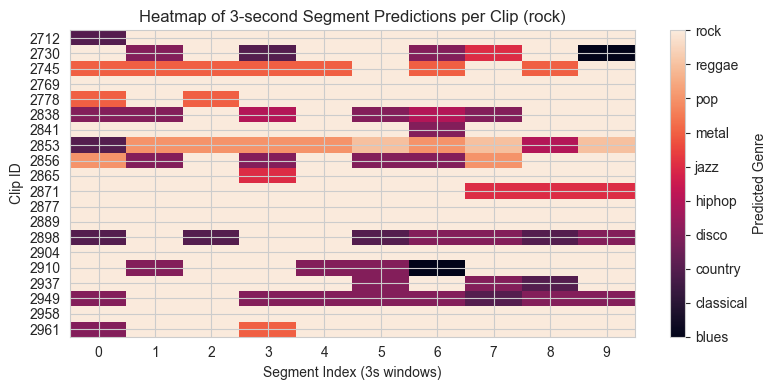

In [74]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(0, 10):
    pivot = (
        test_df[test_df['genre_idx']==i]
        .pivot(index='clip_id', columns='segment_id', values='pred_seg')
        .sort_index()
        .sort_index(axis=1)
    )
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(pivot.values, aspect='auto', vmin=0, vmax=9)
    
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    
    label = le.inverse_transform([i])
    
    ax.set_xlabel('Segment Index (3s windows)')
    ax.set_ylabel('Clip ID')
    ax.set_title(f'Heatmap of 3-second Segment Predictions per Clip ({label[0]})')
    
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(10))
    cbar.ax.set_yticklabels(le.inverse_transform(np.arange(10)))
    cbar.set_label('Predicted Genre')
    
    plt.tight_layout()
    plt.show()